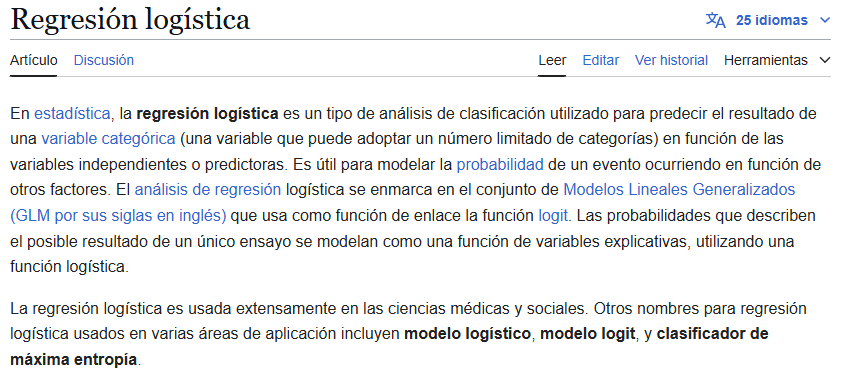
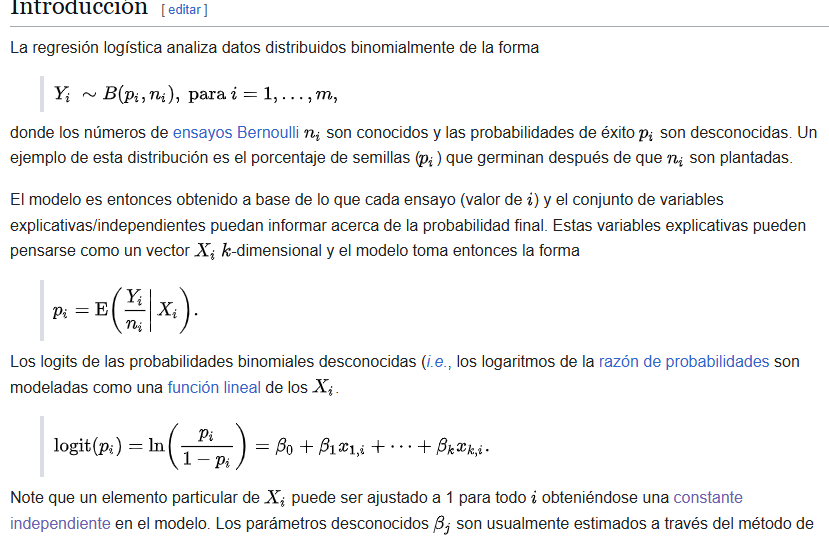
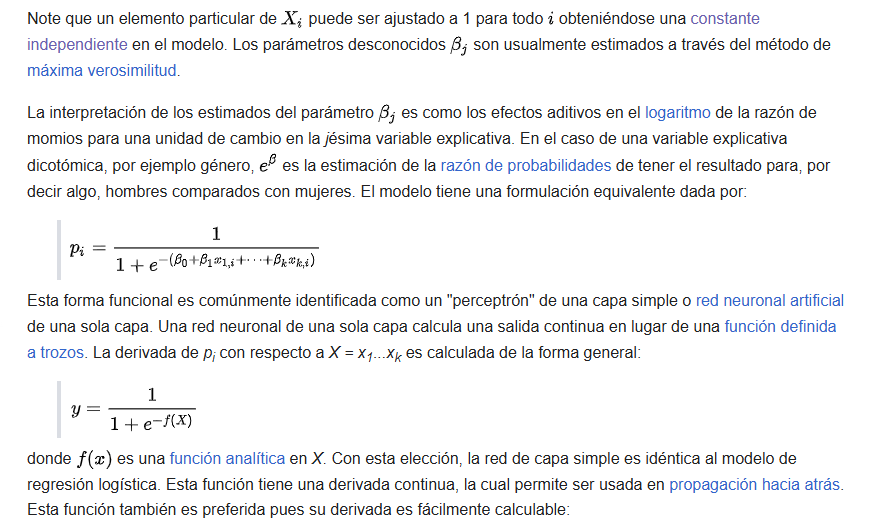
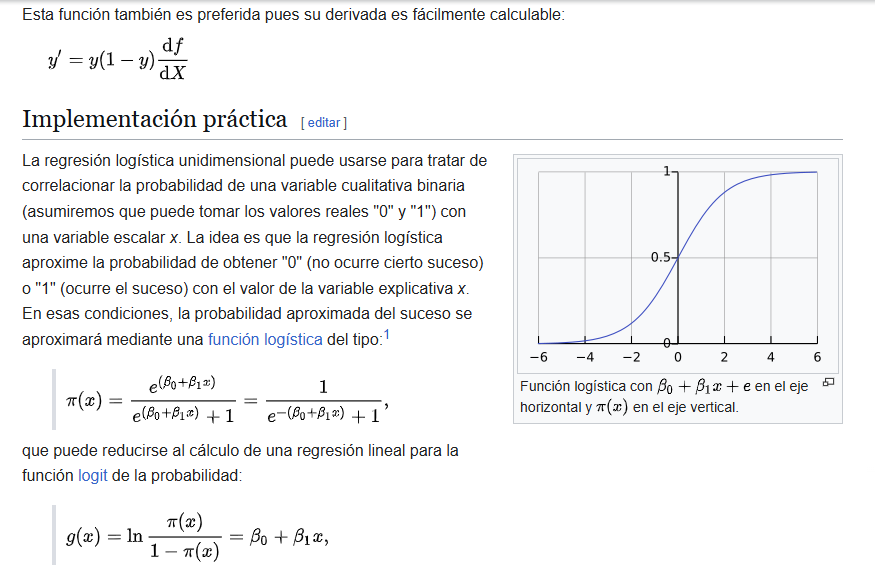
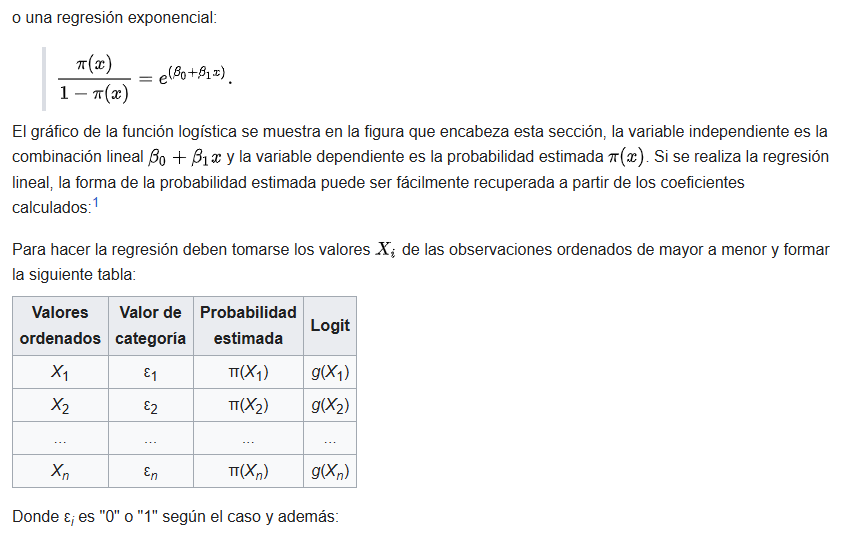

# Propuesta: Sistema de Aprendizaje Automático para Clasificación de Correos SPAM

**Se propone la construcción de un sistema de aprendizaje automático** diseñado para predecir si un correo determinado se corresponde con un correo de **SPAM** o **NO SPAM**.  

Para ello, se utilizará el conjunto de datos **2007 TREC Public Spam Corpus**, ampliamente reconocido por su relevancia y calidad en investigaciones relacionadas con el filtrado de correos electrónicos. Este sistema busca mejorar la precisión en la detección de mensajes no deseados, contribuyendo a la organización y seguridad del correo electrónico.



En este caso practico relacionado con la detección de correos electrónicos de SPAM, el conjunto de datos de que disponemos
está formado por correos electrónicos, con sus correspondientes cabeceras y campos adicionales. Por lo tanto, requieren un preprocesamiento previo  para puedan ser ingeridos por los algoritmos de ML. 

¿Qué hace la clase MLStripper?
La clase MLStripper recibe un contenido en HTML, como un correo electrónico con formato HTML (por ejemplo, un mensaje con etiquetas <b>, <p>, <a>, etc.), y extrae solo el texto,
eliminando todas las etiquetas HTML.

**Ejemplo**
<p>Hola, <b>mundo</b>! <a href="https://example.com">Haz clic aquí</a></p>


Lo que hace la clase MLStripper es quitar todo el código HTML (las etiquetas <p>, <b>, <a>, etc.) y solo dejar el texto. El resultado sería:
Hola, mundo Haz clicc aquí.


Desglose de los métodos:
__init__:
Prepara el objeto para procesar el HTML, configurando todo lo necesario (como la lista fed para almacenar el texto limpio).

handle_data(d):
Cuando encuentra texto en el HTML, lo guarda en la lista fed.

get_data():
Devuelve todo el texto que ha guardado, ahora limpio, es decir, sin etiquetas HTML.

##self.reset():
Llama al método reset() de la clase base HTMLParser.
Este método restablece el estado interno del parser de HTML, es decir, limpia cualquier estado previo y prepara el objeto para procesar un nuevo conjunto de datos (HTML). En este caso, es importante porque cada vez que se alimenta nuevo contenido HTML al objeto, necesitas empezar desde cero.

self.strict = False:

strict es un parámetro que viene de la clase base HTMLParser.
Cuando está en False, el parser permite ciertos errores o contenido HTML "mal formado" sin lanzar excepciones.
Si se pone a True, el parser se vuelve más estricto y rechazará el HTML mal formado o incorrecto.
En este caso, se establece en False porque probablemente el objetivo sea procesar HTML que no siempre esté perfectamente formado (como el que puede llegar en correos electrónicos).

self.convert_charrefs = True:

Este es otro parámetro de HTMLParser.
Si se establece en True, cualquier referencia a caracteres especiales en el HTML (como &amp; para &, &lt; para <, etc.) será convertida automáticamente a sus equivalentes en texto (&, <, etc.).
Este parámetro asegura que el texto extraído contenga los caracteres reales en lugar de las secuencias de escape HTML

self.fed = []:

self.fed es una lista vacía que se utiliza para almacenar el texto que se va extrayendo del contenido HTML.
El método handle_data(d) agrega el texto limpio (sin las etiquetas HTML) a esta lista.
Más tarde, con el método get_data(), esta lista se convierte en una cadena de texto al unir todos los elementos con ''.join(self.fed).

In [2]:
#Esta clase facilita el preprocesamiento de correos electrónicos que poseen codigo HTML enbebido
from html.parser import HTMLParser

# Esta clase facilita el preprocesamiento de correos electrónicos con código HTML incrustado
class MLStripper(HTMLParser):
    
    def __init__(self):  # Se configura el constructor con los parámetros iniciales
        self.reset()  # Reinicia el estado interno del parser
        self.strict = False                            #Controla si el parseador debe ser estricto en cuanto a reglas de html, permite ciertos errores html
        
        """Valor True: Activa la conversión automática de las referencias de caracteres HTML.
        Si el HTML contiene caracteres especiales representados por entidades como &amp;, 
        estos se convertirán al carácter correspondiente (en este caso, &)"""
        
        self.convert_charrefs=True 
        self.fed = []  # Lista para almacenar los datos de texto

    def handle_data(self, d):  # Este método recibe el texto entre las etiquetas HTML
        self.fed.append(d)  # Almacena el texto plano en la lista

    def get_data(self):  # Retorna el texto limpio sin las etiquetas HTML
        return ''.join(self.fed)


El metodo feed() es heredado de la clase MLStripper y es fundamental para alimentar el parseador y luego mas adelante 
obtener el texto plano limpio

In [4]:
# Esta función se encarga de eliminar los tags HTML que se encuentran en el texto del correo electrónico
def strip_tags(html):
    s = MLStripper()  # Creamos el objeto MLStripper
    s.feed(html)  # Alimentamos el contenido HTML al parseador (usamos feed, no fed)
    return s.get_data()  # Retornamos el texto limpio

In [6]:
html = '<html>\
  <head>\
    <title>Ejemplo de correo</title>\
  </head>\
  <body>\
    <h1>Bienvenido a nuestro boletín</h1>\
    <p>Estimado usuario,</p>\
    <p>Gracias por suscribirte a nuestras noticias. Este es un <b>ejemplo de correo</b> HTML con <a href="https://www.ejemplo.com">enlace</a>.</p>\
    <p>Esperamos que disfrutes de nuestro contenido.</p>\
    <footer>Este correo fue enviado por <a href="https://www.ejemplo.com">Ejemplo</a>.</footer>\
  </body>\
</html>'

texto_limpio = strip_tags(html)
print(texto_limpio)


      Ejemplo de correo        Bienvenido a nuestro boletín    Estimado usuario,    Gracias por suscribirte a nuestras noticias. Este es un ejemplo de correo HTML con enlace.    Esperamos que disfrutes de nuestro contenido.    Este correo fue enviado por Ejemplo.  


Ademas de Eliminar los posibles tags HTML que se encuentren en el correo electronico, deberían realizarce otras acciones de preprocesamiento para evitar que los mensajes tengan ruido innecesario. Entre ellas se encuentra la alimentación con los signos de puntuación, eliminacion de posibles campos del correo electrónico que no sean relevantes o alimentación de los afijos de una palabra manteniendo unicamente la raiz de la misma (Starmming) La clase que hace este trabajo es :

In [8]:
import email
import string
import nltk
nltk.download('stopwords')

class Parser:

    def __init__(self):
        self.stemmer = nltk.PorterStemmer()
        self.stopwords = set(nltk.corpus.stopwords.words('english'))
        self.punctuation = list(string.punctuation)

    def parse(self, email_path):
        """Parse an email."""
        with open(email_path, errors='ignore') as e:
            msg = email.message_from_file(e)
        return None if not msg else self.get_email_content(msg)

    def get_email_content(self, msg):
        """Extract the email content."""
        subject = self.tokenize(msg['Subject']) if msg['Subject'] else []
        body = self.get_email_body(msg.get_payload(),
                                   msg.get_content_type())
        content_type = msg.get_content_type()
        # Returning the content of the email
        return {"subject": subject,
                "body": body,
                "content_type": content_type}

    def get_email_body(self, payload, content_type):
        """Extract the body of the email."""
        body = []
        if type(payload) is str and content_type == 'text/plain':
            return self.tokenize(payload)
        elif type(payload) is str and content_type == 'text/html':
            return self.tokenize(strip_tags(payload))
        elif type(payload) is list:
            for p in payload:
                body += self.get_email_body(p.get_payload(),
                                            p.get_content_type())
        return body

    def tokenize(self, text):
        """Transform a text string in tokens. Perform two main actions,
        clean the punctuation symbols and do stemming of the text."""
        for c in self.punctuation:
            text = text.replace(c, "")
        text = text.replace("\t", " ")
        text = text.replace("\n", " ")
        tokens = list(filter(None, text.split(" ")))
        # Stemming of the tokens
        return [self.stemmer.stem(w) for w in tokens if w not in self.stopwords]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\12345\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [65]:
inmail = open("datasets/trec07p/data/inmail.1").read()
print(inmail)

From RickyAmes@aol.com  Sun Apr  8 13:07:32 2007
Return-Path: <RickyAmes@aol.com>
Received: from 129.97.78.23 ([211.202.101.74])
	by speedy.uwaterloo.ca (8.12.8/8.12.5) with SMTP id l38H7G0I003017;
	Sun, 8 Apr 2007 13:07:21 -0400
Received: from 0.144.152.6 by 211.202.101.74; Sun, 08 Apr 2007 19:04:48 +0100
Message-ID: <WYADCKPDFWWTWTXNFVUE@yahoo.com>
From: "Tomas Jacobs" <RickyAmes@aol.com>
Reply-To: "Tomas Jacobs" <RickyAmes@aol.com>
To: the00@speedy.uwaterloo.ca
Subject: Generic Cialis, branded quality@ 
Date: Sun, 08 Apr 2007 21:00:48 +0300
X-Mailer: Microsoft Outlook Express 6.00.2600.0000
MIME-Version: 1.0
Content-Type: multipart/alternative;
	boundary="--8896484051606557286"
X-Priority: 3
X-MSMail-Priority: Normal
Status: RO
Content-Length: 988
Lines: 24

----8896484051606557286
Content-Type: text/html;
Content-Transfer-Encoding: 7Bit

<html>
<body bgcolor="#ffffff">
<div style="border-color: #00FFFF; border-right-width: 0px; border-bottom-width: 0px; margin-bottom: 0px;" align="

Instanciamos nuestra clase Parser()
El resultado del parseo es un diccionario con las palabras que aparecen en el subject y ademas con laraiz de las palabras,
es decir eliminamos el ruido(palabras innecesarias por ejemplo de branded nos quedamos con el brand)

del body nos quitamos todos los tag html

Parsing Correo electronico

In [67]:
#Parsing correo electronico

p = Parser()
p.parse("datasets/trec07p/data/inmail.1")

{'subject': ['gener', 'ciali', 'brand', 'qualiti'],
 'body': ['do',
  'feel',
  'pressur',
  'perform',
  'rise',
  'occas',
  'tri',
  'viagra',
  'anxieti',
  'thing',
  'past',
  'back',
  'old',
  'self'],
 'content_type': 'multipart/alternative'}

**Lectura del indice**

Las funciones complementarias que siguen se encargan de cargar en memoria la ruta de cada correo electrónico y su etiqueta (Spam, ham)


In [71]:
index = open("datasets/trec07p/full/index").readlines()
index
"""Para el correo electronico por un lado en un fichero index tenemos la itequeta para cada correo y por otro lado tenemos los datos
la idea es leer el fichero y con pandas construr un dataSet o conjunto de datos de tabla de dos dimenciones
"""

['spam ../data/inmail.1\n',
 'ham ../data/inmail.2\n',
 'spam ../data/inmail.3\n',
 'spam ../data/inmail.4\n',
 'spam ../data/inmail.5\n',
 'spam ../data/inmail.6\n',
 'spam ../data/inmail.7\n',
 'spam ../data/inmail.8\n',
 'spam ../data/inmail.9\n',
 'ham ../data/inmail.10\n',
 'spam ../data/inmail.11\n',
 'spam ../data/inmail.12\n',
 'spam ../data/inmail.13\n',
 'spam ../data/inmail.14\n',
 'spam ../data/inmail.15\n',
 'spam ../data/inmail.16\n',
 'spam ../data/inmail.17\n',
 'spam ../data/inmail.18\n',
 'spam ../data/inmail.19\n',
 'ham ../data/inmail.20\n',
 'ham ../data/inmail.21\n',
 'spam ../data/inmail.22\n',
 'spam ../data/inmail.23\n',
 'spam ../data/inmail.24\n',
 'spam ../data/inmail.25\n',
 'spam ../data/inmail.26\n',
 'spam ../data/inmail.27\n',
 'spam ../data/inmail.28\n',
 'ham ../data/inmail.29\n',
 'spam ../data/inmail.30\n',
 'ham ../data/inmail.31\n',
 'spam ../data/inmail.32\n',
 'spam ../data/inmail.33\n',
 'ham ../data/inmail.34\n',
 'spam ../data/inmail.35\n',
 

Funciones auxiliares para parsear el fichero y obtener los indices

In [73]:
#La funcion auxiliar parsea el fichero anterior el index para optener los indices
import os

DATASET_PATH = os.path.join("datasets", "trec07p")

def parse_index(path_to_index, n_elements):
    ret_indexes = []
    index = open(path_to_index).readlines()
    for i in range(n_elements):
        mail = index[i].split(" ../")
        label = mail[0]
        path = mail[1][:-1]
        path_mail = path.split("/")[-1]
        ret_indexes.append({"label":label, "email_path":os.path.join(DATASET_PATH, os.path.join("data", path_mail))})
    return ret_indexes

In [77]:
#Funcion que parsea el fichero y se optiene una lista de diccionarios con la etiqueta ham, span
def parse_email(index):
    p = Parser()
    pmail = p.parse(index["email_path"])
    return pmail, index["label"]

In [79]:
indexes = parse_index("index", 10)
indexes

[{'label': 'spam', 'email_path': 'datasets\\trec07p\\data\\inmail.1'},
 {'label': 'ham', 'email_path': 'datasets\\trec07p\\data\\inmail.2'},
 {'label': 'spam', 'email_path': 'datasets\\trec07p\\data\\inmail.3'},
 {'label': 'spam', 'email_path': 'datasets\\trec07p\\data\\inmail.4'},
 {'label': 'spam', 'email_path': 'datasets\\trec07p\\data\\inmail.5'},
 {'label': 'spam', 'email_path': 'datasets\\trec07p\\data\\inmail.6'},
 {'label': 'spam', 'email_path': 'datasets\\trec07p\\data\\inmail.7'},
 {'label': 'spam', 'email_path': 'datasets\\trec07p\\data\\inmail.8'},
 {'label': 'spam', 'email_path': 'datasets\\trec07p\\data\\inmail.9'},
 {'label': 'ham', 'email_path': 'datasets\\trec07p\\data\\inmail.10'}]

2                                  Preprocesamiento de los datos

Con las funciones presentadas anteriormente se permite la lectura de los correos electrónicos de manera programática y el procesamiento de los mismos para eliminar aquellos componentes que no resultan de utilidad para la detección de correos de SPAM. Sin embargo, cada uno de los correos sigue estando representado por un diccionario de Python con una serie de palabras.

In [81]:
# Cargamos el índice y las etiquetas en memoria
index = parse_index("index", 1)

In [83]:
# Leemos el primer correo
import os

open(index[0]["email_path"]).read()

'From RickyAmes@aol.com  Sun Apr  8 13:07:32 2007\nReturn-Path: <RickyAmes@aol.com>\nReceived: from 129.97.78.23 ([211.202.101.74])\n\tby speedy.uwaterloo.ca (8.12.8/8.12.5) with SMTP id l38H7G0I003017;\n\tSun, 8 Apr 2007 13:07:21 -0400\nReceived: from 0.144.152.6 by 211.202.101.74; Sun, 08 Apr 2007 19:04:48 +0100\nMessage-ID: <WYADCKPDFWWTWTXNFVUE@yahoo.com>\nFrom: "Tomas Jacobs" <RickyAmes@aol.com>\nReply-To: "Tomas Jacobs" <RickyAmes@aol.com>\nTo: the00@speedy.uwaterloo.ca\nSubject: Generic Cialis, branded quality@ \nDate: Sun, 08 Apr 2007 21:00:48 +0300\nX-Mailer: Microsoft Outlook Express 6.00.2600.0000\nMIME-Version: 1.0\nContent-Type: multipart/alternative;\n\tboundary="--8896484051606557286"\nX-Priority: 3\nX-MSMail-Priority: Normal\nStatus: RO\nContent-Length: 988\nLines: 24\n\n----8896484051606557286\nContent-Type: text/html;\nContent-Transfer-Encoding: 7Bit\n\n<html>\n<body bgcolor="#ffffff">\n<div style="border-color: #00FFFF; border-right-width: 0px; border-bottom-width: 0

El algoritmo de regresion logistica no es capaz de ingerir texto como parte del conjunto de datos. Por lo tnto, de3ben aplicarse una serie de funciones adicionales que transforman el texto de los correos electrónicos parseados en una representación numérica.

In [85]:
# Parseamos el primer correo electronico de la list en el diccionario
mail, label = parse_email(index[0])
print("El correo es:", label)
print(mail)

El correo es: spam
{'subject': ['gener', 'ciali', 'brand', 'qualiti'], 'body': ['do', 'feel', 'pressur', 'perform', 'rise', 'occas', 'tri', 'viagra', 'anxieti', 'thing', 'past', 'back', 'old', 'self'], 'content_type': 'multipart/alternative'}


""""El correo electronico en este punto se ha parseado y tenemos un texto limpio, sin ruido, ahora lo que corresponde es construir una tabala }
o dataFrame con las palabras del email, donde cada palabra que no se repite constituye una columna. Hecho esto durante el proceso se verifica si el 
email tiene la palabra clave en i.esima columna si la tiene se asigna un 1 y si no la tiene se asigna un cero y al final en la ultima columna asignamos una etiqueta Y(0,1).

Este proceso se conoce como vectorizado"""

In [87]:
from sklearn.feature_extraction.text import CountVectorizer

# Preapración del email en una cadena de texto
prep_email = [" ".join(mail['subject']) + " ".join(mail['body'])]

vectorizer = CountVectorizer()
X = vectorizer.fit(prep_email)

print("Email:", prep_email, "\n")
print("Características de entrada:", vectorizer.get_feature_names_out())

Email: ['gener ciali brand qualitido feel pressur perform rise occas tri viagra anxieti thing past back old self'] 

Características de entrada: ['anxieti' 'back' 'brand' 'ciali' 'feel' 'gener' 'occas' 'old' 'past'
 'perform' 'pressur' 'qualitido' 'rise' 'self' 'thing' 'tri' 'viagra']


In [89]:
#En este punto obtenemos un vctor numerico
X = vectorizer.transform(prep_email)
print("\nValues:\n", X.toarray())

#Aparecen todoas las palabras en 1 por que tenemos un solo correo electrónico


Values:
 [[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]]


Aplicacion de OneHotEncoding

In [92]:
from sklearn.preprocessing import OneHotEncoder

prep_email = [[w] for w in mail['subject'] + mail['body']]

enc = OneHotEncoder(handle_unknown='ignore')
X = enc.fit_transform(prep_email)

print("Features:\n", enc.get_feature_names_out())
print("\nValues:\n", X.toarray())

Features:
 ['x0_anxieti' 'x0_back' 'x0_brand' 'x0_ciali' 'x0_do' 'x0_feel' 'x0_gener'
 'x0_occas' 'x0_old' 'x0_past' 'x0_perform' 'x0_pressur' 'x0_qualiti'
 'x0_rise' 'x0_self' 'x0_thing' 'x0_tri' 'x0_viagra']

Values:
 [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

##### Funciones auxiliares para preprocesamiento del conjunto de datos

In [99]:
def create_prep_dataset(index_path, n_elements):
    X = []
    y = []
    indexes = parse_index(index_path, n_elements)
    for i in range(n_elements):
        print("\rParsing email: {0}".format(i+1), end='')
        try:
            mail, label = parse_email(indexes[i])
            X.append(" ".join(mail['subject']) + " ".join(mail['body']))
            y.append(label)
        except:
            pass
    return X, y

### 3. Entrenamiento del algoritmo 

In [101]:
# Leemos únicamente un subconjunto de 100 correos electrónicos
X_train, y_train = create_prep_dataset("datasets/trec07p/full/index", 100)
X_train

Parsing email: 100

['gener ciali brand qualitido feel pressur perform rise occas tri viagra anxieti thing past back old self',
 'typo debianreadmhi ive updat gulu i check mirror it seem littl typo debianreadm file exampl httpgulususherbrookecadebianreadm ftpftpfrdebianorgdebianreadm test lenni access releas diststest the current test develop snapshot name etch packag test unstabl pass autom test propog releas etch replac lenni like readmehtml yan morin consult en logiciel libr yanmorinsavoirfairelinuxcom 5149941556 to unsubscrib email debianmirrorsrequestlistsdebianorg subject unsubscrib troubl contact listmasterlistsdebianorg',
 'authent viagramega authenticv i a g r a discount pricec i a l i s discount pricedo miss it click httpwwwmoujsjkhchumcom authent viagra mega authenticv i a g r a discount pricec i a l i s discount pricedo miss it click',
 'nice talk yahey billi realli fun go night talk said felt insecur manhood i notic toilet quit small area worri websit i tell secret weapon extra 3 inch trust g

Aplicamos la vectorización a los datos

In [103]:
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)

In [105]:
print(X_train.toarray())
print("\nFeatures:", len(vectorizer.get_feature_names_out()))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Features: 4987


In [107]:
import pandas as pd

pd.DataFrame(X_train.toarray(), columns=[vectorizer.get_feature_names_out()])

,0000,000000,00085,002,003,00450,009,01,01000u,0107,...,õôõôèõéï,ö¹,öð,öôööµæ,öø³ðåµ,öþ,öˆ,úàí,þîñòµ¼,šè
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
96,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
98,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [109]:
y_train

['spam',
 'ham',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'ham',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'ham',
 'ham',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'ham',
 'spam',
 'ham',
 'spam',
 'spam',
 'ham',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'ham',
 'ham',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'ham',
 'spam',
 'ham',
 'spam',
 'spam',
 'ham',
 'spam',
 'spam',
 'spam',
 'ham',
 'ham',
 'spam',
 'spam',
 'spam',
 'ham',
 'ham',
 'ham',
 'spam',
 'ham',
 'spam',
 'ham',
 'spam',
 'spam',
 'spam',
 'ham',
 'spam',
 'spam',
 'ham',
 'spam',
 'ham',
 'spam',
 'spam',
 'ham',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam',
 'spam']

Entrenamiento del algoritmo de regresión logística con el conjunto de datos preprocesado

In [111]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

4. Predicción

In [113]:
# Leemos 150 correos de nuestro conjunto de datos y nos quedamos únicamente con los 50 últimos 
# Estos 50 correos electrónicos no se han utilizado para entrenar el algoritmo
X, y = create_prep_dataset("datasets/trec07p/full/index", 150)
X_test = X[100:]
y_test = y[100:]

Parsing email: 150

Preprocesamiento de los correos con el vectorizador creado anteriormente

In [115]:
X_test = vectorizer.transform(X_test)

Predicción del tipo de correo

In [117]:
y_pred = clf.predict(X_test)
y_pred

array(['spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam',
       'spam', 'spam', 'ham', 'spam', 'spam', 'spam', 'spam', 'spam',
       'ham', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam',
       'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam',
       'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam',
       'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam',
       'spam'], dtype='<U4')

In [119]:
print("Predicción:\n", y_pred)
print("\nEtiquetas reales:\n", y_test)

Predicción:
 ['spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam'
 'ham' 'spam' 'spam' 'spam' 'spam' 'spam' 'ham' 'spam' 'spam' 'spam'
 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam'
 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam'
 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam' 'spam']

Etiquetas reales:
 ['spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'ham', 'spam', 'spam', 'spam', 'spam', 'spam', 'ham', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'ham', 'spam', 'spam', 'ham', 'spam', 'ham', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam', 'spam']


Evaluación de los resultados

In [121]:
from sklearn.metrics import accuracy_score

print('Accuracy: {:.3f}'.format(accuracy_score(y_test, y_pred)))

Accuracy: 0.939


. Aumentando el conjunto de datos

In [123]:
# Leemos 12000 correos electrónicos
X, y = create_prep_dataset("datasets/trec07p/full/index", 12000)

Parsing email: 12000

In [127]:
#Utilizamos 10000 correos electrónicos para entrenar el algoritmo y 2000 para realizar pruebas
X_train, y_train = X[:10000], y[:10000]
X_test, y_test = X[10000:], y[10000:]

In [129]:
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)

In [131]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

In [133]:
X_test = vectorizer.transform(X_test)

In [135]:
y_pred = clf.predict(X_test)

In [137]:
print('Accuracy: {:.3f}'.format(accuracy_score(y_test, y_pred)))

Accuracy: 0.987
